In [1]:
from QL.environment import Maze

from QL.RL_brain import QLearningTable
import numpy as np

env = Maze()
RL = QLearningTable(actions=list(range(env.n_actions)))

def give_me_fidelity(N):

    dt     = 2 * np.pi/N   
    ep_max = 500
    fidelity=np.zeros(ep_max)

    RL       = QLearningTable(actions=list(range(env.n_actions)))

    fid_10 = 0
    for episode in range(ep_max):
        observation = env.reset()
        while True:
            
            action = RL.choose_action(str(observation))    
            observation_, reward, done, fid = env.step(action)
            RL.learn(str(observation), action, reward, str(observation_))
            observation = observation_
            if done:
                if episode >= ep_max-11:
                    fid_10 = max(fid_10,fid)
                break
                
    print('Final_fidelity for QL for  {N} '.format(N=N),fid_10)

    return fid_10



In [2]:
import numpy as np
from scipy.linalg import expm

from matplotlib import pyplot as plt


def calculate_cost(sequence):

    length = len(sequence) 
    time_step = 2*np.pi/length  

    sigma_x = 1/2 * np.mat([[0,1],\
                 [1,0]], dtype=complex)
    sigma_z = 1/2 * np.mat([[1,0],\
                 [0,-1]], dtype=complex)

    evolution_operator = np.matrix(np.identity(2, dtype=complex)) # Initial Evolution operator

    control_strength = 4  # Control field strength

    for action in sequence:
        hamiltonian = action * control_strength * sigma_z + 1*sigma_x # Hamiltonian
        evolution_operator = expm(-1j * hamiltonian * time_step) * evolution_operator  # Evolution operator

    initial_state = np.mat([[1],[0]], dtype=complex) # Initial state
    final_state = evolution_operator * initial_state  # Final state

    target_state = np.mat([[0], [1]], dtype=complex)                             # Target state (south pole)

    error = 1 - (np.abs(final_state.H * target_state)**2).item(0).real  # Infidelity (to minimize)

    return error


step_size = 0.01
cost_history = []

def gradient_descent(sequence, dimension, learning_rate, num_iterations):
    for _ in range(num_iterations):
        random_vector = np.random.rand(dimension) 
        sequence_plus = sequence + random_vector * step_size
        sequence_minus = sequence - random_vector * step_size
        error_derivative = (calculate_cost(sequence_plus) - calculate_cost(sequence_minus)) / (2 * step_size)
        sequence = sequence - (learning_rate) * error_derivative * random_vector
        cost_history.append(calculate_cost(sequence_plus))
        # print(calculate_cost(sequence))


    return calculate_cost(sequence)


def sgd(N):

    sequence_length = N
    random_sequence = np.random.rand(sequence_length)
    max_epochs = 500
    final_fidelity = 1 - gradient_descent(random_sequence, sequence_length, 0.01, max_epochs)

    print('Final Fidelity for sgd for {N}:'.format(N=sequence_length), final_fidelity)

    return final_fidelity


In [3]:
# importing essential libraries

import numpy as np
from scipy import linalg

# Pauli's 3 gates

sx = 1/2 * np.mat([[0, 1],[ 1, 0]], dtype=complex)
sy = 1/2 * np.mat([[0, -1j],[1j, 0]], dtype=complex)
sz = 1/2 * np.mat([[1, 0],[0, -1]], dtype=complex)

def hamiltonian(j):
    J = 4
    H = (j) * J * sz + sx
    return H


def krotov(N):

    T = 2*np.pi       
    dt = T/N

    I = 500
    fidelity = np.zeros(I+1)

    observable = np.mat(np.zeros(shape=(2,2), dtype=complex))
    observable[-1, -1] = 1

    psi = np.mat(np.zeros(shape=(2, N+1), dtype=complex))
    psi[0,0] = 1   
    pseudo = np.mat(np.zeros(shape=(2, N+1), dtype=complex))    # 


    seq = np.random.rand(N)
    seq_f = seq

    for i in range(N):
        psi[:,i+1] = linalg.expm(-(1j) * hamiltonian(seq[i]) * dt).dot(psi[:,i])
    fidelity[0]=(np.absolute(psi[-1,-1]))**2
    pseudo[:,-1] = observable.dot(psi[:,-1])
    dj = 0.01    


    for i in range(I):
        for j in reversed(range(N)):
            pseudo[:,j] = linalg.expm((1j) * hamiltonian(seq[j]) * dt).dot(pseudo[:,j+1])
        for k in range(N):
            dH = (hamiltonian(seq[k]+dj) - hamiltonian(seq[k]-dj)) / (2*dj)
            seq_f[k] = seq[k] + (pseudo[:,k].conj().T.dot(dH.dot(psi[:,k]))).imag[0,0]
            psi[:,k+1] = linalg.expm(-(1j) * hamiltonian(seq_f[k]) * dt).dot(psi[:,k])
            seq = seq_f
        fidelity[i+1] += (np.absolute(psi[-1,-1]))**2
        pseudo[:,-1] = observable.dot(psi[:,-1])

    print("Final_fidelity for krotov for {i}".format(i=N),fidelity[-1])
    return fidelity[-1]

# N=20
# print('final_fidelity=',krotov(N) )



In [4]:
fid_list_QL=[]
fid_list_sgd=[]
fid_list_krotov=[]

for i in range(1,50,5):
    fid_list_QL.append(give_me_fidelity(i))
    fid_list_sgd.append(sgd(i))
    fid_list_krotov.append(krotov(i))


    

Final_fidelity for QL for  1  0.6040453723945125
Final Fidelity for sgd for 1: 0.465751046171623
Final_fidelity for krotov for 1 0.02717864247038018
Final_fidelity for QL for  6  0.48443150613745806
Final Fidelity for sgd for 6: 0.9954364877302726
Final_fidelity for krotov for 6 0.4740060538277772
Final_fidelity for QL for  11  0.5989331891829894
Final Fidelity for sgd for 11: 0.8790594363541965
Final_fidelity for krotov for 11 0.9919701786031033
Final_fidelity for QL for  16  0.43595633722192606
Final Fidelity for sgd for 16: 0.19820340307107942
Final_fidelity for krotov for 16 0.9999999999999996
Final_fidelity for QL for  21  0.5426506220263116
Final Fidelity for sgd for 21: 0.6762173293392879
Final_fidelity for krotov for 21 1.0
Final_fidelity for QL for  26  0.5108428664119308
Final Fidelity for sgd for 26: 0.44203320989403605
Final_fidelity for krotov for 26 0.9999999999999998
Final_fidelity for QL for  31  0.6870946513340641
Final Fidelity for sgd for 31: 0.2573681029507149
Final

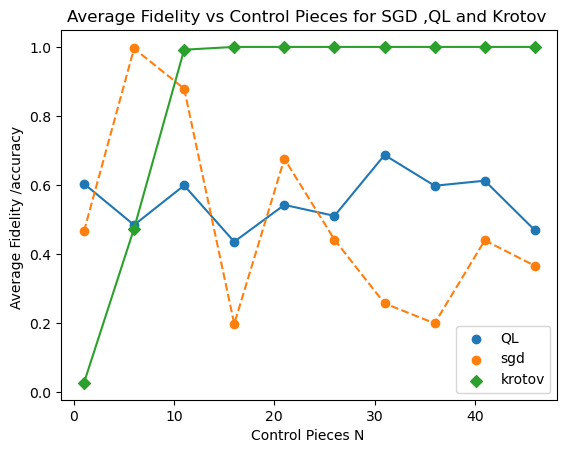

In [7]:


x=[i for i in range(1,50,5)]
plt.scatter(x,fid_list_QL,label="QL")
plt.plot(x,fid_list_QL,"-")
plt.scatter(x,fid_list_sgd,label="sgd")
plt.plot(x,fid_list_sgd,"--")

plt.scatter(x,fid_list_krotov,marker="D",label="krotov")
plt.plot(x,fid_list_krotov,"-")

plt.legend()
plt.xlabel("Control Pieces N ")
plt.ylabel("Average Fidelity /accuracy ")
plt.title("Average Fidelity vs Control Pieces for SGD ,QL and Krotov ")
plt.show()